# **Imports**

In [ ]:
import xml.etree.ElementTree as elemT
import re
import pandas as pd
import numpy as np
import seaborn as sb
import nltk
from nltk.corpus import stopwords as sw
from nltk.tokenize import TreebankWordTokenizer as twt
import spacy
from google.colab import files
from google.colab import drive
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA

nltk.download("stopwords")
!python -m spacy download fr

drive.mount("/content/gdrive", force_remount=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 14.7MB 3.9MB/s 
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.2.5-cp36-none-any.whl size=14727027 sha256=c69b43ae5a5112e16693d00f34d42f63163880bb39aa23c1193f5342f9106dfa
  Stored in directory: /tmp/pip-ephem-wheel-cache-x7d6vzdq/wheels/46/1b/e6/29b020e3f9420a24c3f463343afe5136aaaf955dbc9e46dfc5
Successfully built fr-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/fr_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/fr
You can now load the model via spacy.load('fr')
Mounted at /content/gdrive


# **Dataframe creation**

In [ ]:
def CreateDataFrame(fileCSV):
    tree = elemT.parse("gdrive/My Drive/Colab Notebooks/Adv. Machine Learning/" + fileCSV)
    root = tree.getroot()

    allText = []

    for child in root:
        corpus = ""
        title = ""
        date = ""
        abstract = ""
        keyword = ""

# Occupons nous des textes en français car ils composent la majorité du corpus (environ 1500 sur 1600)
        if child.get("{http://www.w3.org/XML/1998/namespace}lang") == "fr":
            title = GetRidOfLineBreak(str(child[0][0][0][0].text).lower())
            date = GetRidOfLineBreak(str(child[0][0][1][2].text).lower())
            abstract = GetRidOfLineBreak(str(child[1][0][0][0].text).lower())
            keyword = GetRidOfLineBreak(str(child[1][0][2][0].text).lower())
            for i in range(len(child[1][1])):
                for j in range(len(child[1][1][i])):
                    if len(child[1][1][i]) > 1:
                        for k in range(len(child[1][1][i][j])):
                            tempTxt = GetRidOfLineBreak(str(child[1][1][i][j][k].text).lower() + " ")
                            corpus = corpus + tempTxt
                    else:
                        tempTxt = GetRidOfLineBreak(str(child[1][1][i][j].text).lower() + " ")
                        corpus = corpus + tempTxt
            allText.append([title, date, abstract, corpus, keyword])
        
    df = pd.DataFrame(allText,columns=["Title", "Date", "Abstract", "Corpus", "Keyword"])
    return df

def GetRidOfLineBreak(string):
    regex = re.compile(r'[\n\r\t]')
    return regex.sub(" ", string)

df = CreateDataFrame("corpus_taln_v1.tei.xml")

In [ ]:
df.head()

Title  ... Keyword
0   éléments de conception d'un système d'interpr...  ...    none
1   informatisation du dictionnaire explicatif et...  ...    none
2   construction d'une représentation sémantique ...  ...    none
3   systèmes de types pour la (lambda-)drt ascend...  ...    none
4   une grammaire tag vue comme une grammaire sen...  ...    none

[5 rows x 5 columns]

# **Preprocessing**

In [ ]:
def GetRidOfApostrophe(df, column):
    replacements = (("d\'", "de "), ("qu\'", "que "), ("l\'", "le "), ("j\'", "je "), ("c\'", "ce "), ("s\'", "se "), ("n\'", "ne "), ("m\'", "me "), ("t\'", "te "))
    for replacement in replacements:
        df[column] = df[column].str.replace(*replacement)

def GetRidOfSpecialCharacter(df, column):
    df[column] = df[column].str.replace('[\-\[\]+;\'!\^:/,"#&@\(\)\$\?%\_\*«»]|[A-Z]\.|None|', "")

def GetRidOfAccent(df, column):
    replacements = (("[éèêë]", "e"), ("[àâ]", "a"), ("[ùûü]", "u"), ("[ïî]", "i"), ("[ö]", "o"), ("[ç]", "c"))
    for replacement in replacements:
        df[column] = df[column].str.replace(*replacement)

In [ ]:
def Preprocessing(df):
    columns = ["Title", "Date", "Abstract", "Corpus", "Keyword"]
    for column in columns:
        GetRidOfApostrophe(df, column)
        GetRidOfSpecialCharacter(df, column)
        GetRidOfAccent(df, column)

Preprocessing(df)

In [ ]:
df.head()

Title  ... Keyword
0    element de conception de un systeme de inter...  ...    none
1    informatisation de dictionnaire explicatif e...  ...    none
2    construction de un representation semantique...  ...    none
3        systeme de type pour le  lambdadrtascendant  ...    none
4    un grammaire tag vue comme un grammair sens ...  ...    none

[5 rows x 5 columns]

In [ ]:
def UseStopWords(df):
    stopWords = sw.words("french")
    columns = ["Title", "Abstract", "Corpus", "Keyword"]

    for column in columns:
        df[column] = df[column].apply(lambda i : ' '.join([word for word in i.split() if word not in stopWords]))

    # df["Title"] = df["Title"].apply(lambda i : ' '.join([word for word in i.split() if word not in stopWords]))
    # df["Abstract"] = df["Abstract"].apply(lambda i : ' '.join([word for word in i.split() if word not in stopWords]))
    # df["Corpus"] = df["Corpus"].apply(lambda i : ' '.join([word for word in i.split() if word not in stopWords]))
    # df["Keyword"] = df["Keyword"].apply(lambda i : ' '.join([word for word in i.split() if word not in stopWords]))

UseStopWords(df)

In [ ]:
df.head()

Title  ... Keyword
0  element conception systeme interpretation auto...  ...    none
1  informatisation dictionnaire explicatif etcomb...  ...    none
2  construction representation semantique graphe ...  ...    none
3                    systeme type lambdadrtascendant  ...    none
4  grammaire tag vue comme grammair sens textepre...  ...    none

[5 rows x 5 columns]

In [ ]:
nlp = spacy.load("fr")
columns = ["Title", "Abstract", "Corpus"]

for index, row in df.iterrows():
    for column in columns:
        doc = nlp(row[column])
        result = ""
        count = 0
        for token in doc:
          result = result + token.lemma_
          count = count + 1
          if count < len(doc)-1:
            result = result + " "
        row[column] = result

In [ ]:
df.head()

Title  ... Keyword
0    élément de conception de un système de inter...  ...    none
1    informatisation de dictionnaire explicatif e...  ...    none
2    construction de un représentation sémantique...  ...    none
3     système de type pour le ( lambda-)drtascendant  ...    none
4    un grammaire tag vue comme un grammair sens ...  ...    none

[5 rows x 5 columns]

In [ ]:
nlp = spacy.load("fr")

doc = nlp("on s'appelle")
for token in doc:
    print(token, token.lemma_)

on on
s' se
appelle appeler


In [ ]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def CreateTokenizedDataFrame(df):
    dfToken = df.copy()
    columns = ["Title", "Date", "Abstract", "Corpus", "Keyword"]
    for column in columns:
        for index, row in dfToken.iterrows():
                row[column] = word_tokenize(row[column], language='french')
    return dfToken

dfToken = CreateTokenizedDataFrame(df)

# content_french = ("John Richard Bond explique le rôle de l'astronomie.")
# word_tokenize(content_french, language='french')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
dfToken.head()

Title  ... Keyword
0  [element, conception, systeme, interpretation,...  ...  [none]
1  [informatisation, dictionnaire, explicatif, et...  ...  [none]
2  [construction, representation, semantique, gra...  ...  [none]
3                [systeme, type, lambdadrtascendant]  ...  [none]
4  [grammaire, tag, vue, comme, grammair, sens, t...  ...  [none]

[5 rows x 5 columns]

# **Analyse**

NUAGE DE MOTS

Nous proposons d'analyser les nuages de mots de chaque Abstract trié par année afin de voir l'évolution des thèmes au fil du temps.

In [ ]:
df.sort_values(by="Date", ascending=True)

Title  ...                                            Keyword
0     [element, conception, systeme, interpretation,...  ...                                             [none]
1     [informatisation, dictionnaire, explicatif, et...  ...                                             [none]
2     [construction, representation, semantique, gra...  ...                                             [none]
15                          [formalisme, ledeplacement]  ...                                             [none]
14    [conception, implementation, indexation, balem...  ...                                             [none]
...                                                 ...  ...                                                ...
1477  [exploration, apprentissage, transfert, analys...  ...  [apprentissage, transfert, contenus, reseaux, ...
1478                [explorer, informativite, unphrase]  ...  [informativite, plongements, mots, classificat...
1479  [hybridation, agent, conversationnel, plongeme...  ...  [agents, conversationnels, chatbots, medecine,...
1472  [detecter, nonadherence, medicamenteux, forum,...  ...  [recherche, information, requetes, forums, non...
1501  [polylexfle, base, donnee, expression, polylex...  ...  [expressions, polylexicales, vebales, niveau, ...

[1502 rows x 5 columns]

In [ ]:
def MakeWordCloud(corpus):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

1997


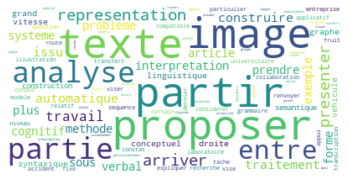

1998


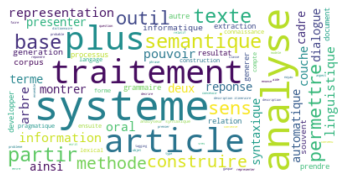

1999


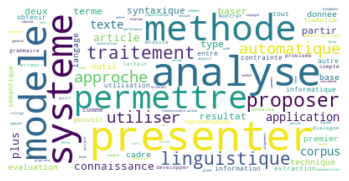

2000


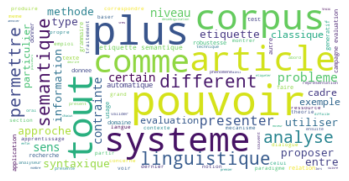

2001


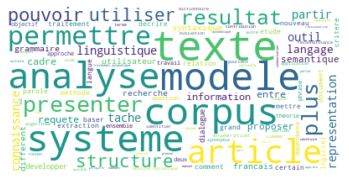

2002


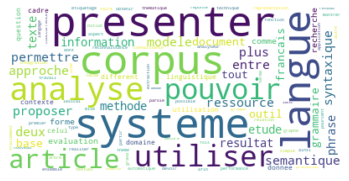

2003


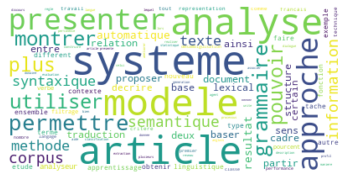

2004


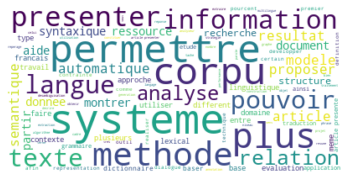

2005


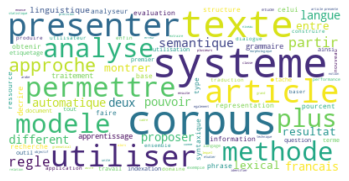

2006


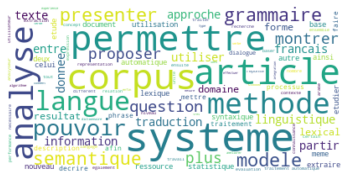

2007


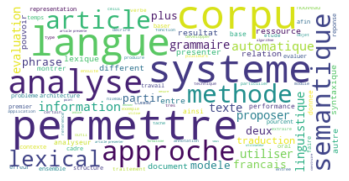

2008


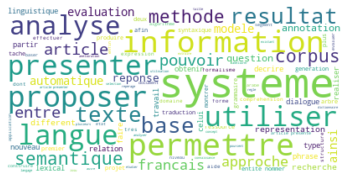

2009


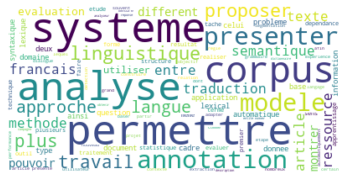

2010


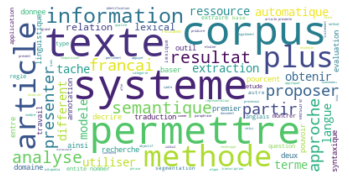

2011


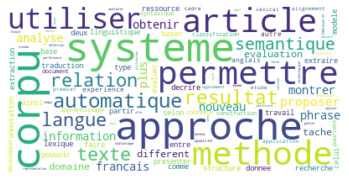

2012


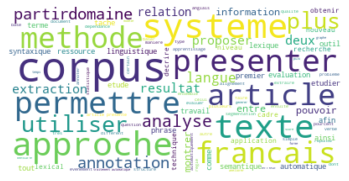

2013


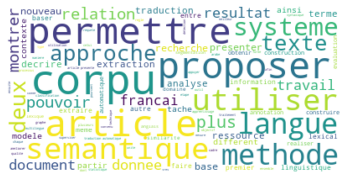

2014


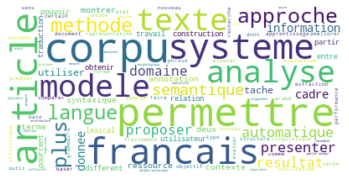

2015


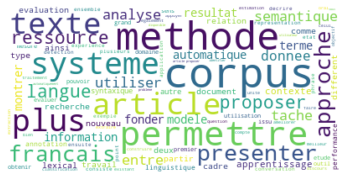

2016


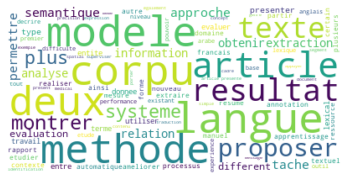

2017


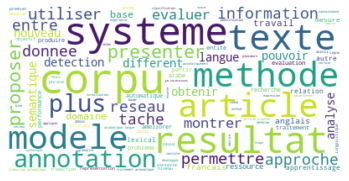

2018


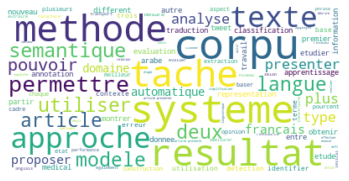

In [ ]:
# Nuage de mots : Abstract
dateMemory = df.iloc[0]["Date"]
corpus = ""

for index, row in df.iterrows():
    if row["Date"] == dateMemory:
        corpus = corpus + row["Abstract"]
    else:
        print(dateMemory)
        MakeWordCloud(corpus)
        dateMemory = row["Date"]
        corpus = row["Abstract"]

1997


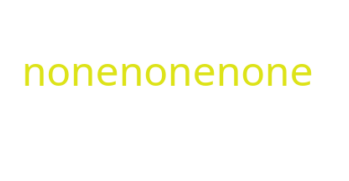

1998


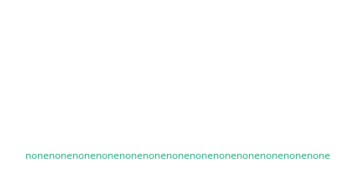

1999


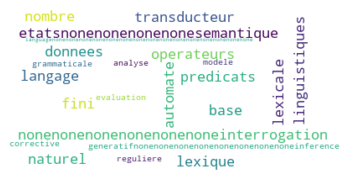

2000


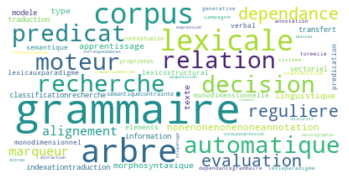

2001


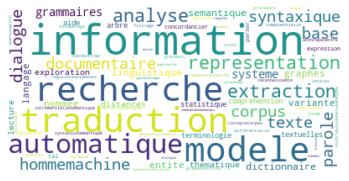

2002


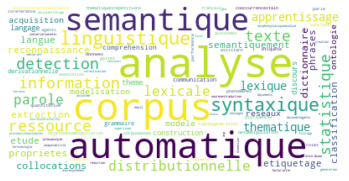

2003


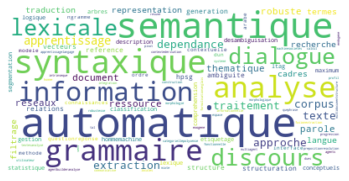

2004


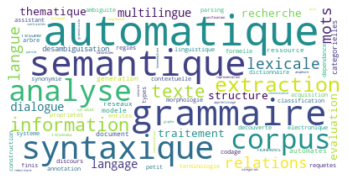

2005


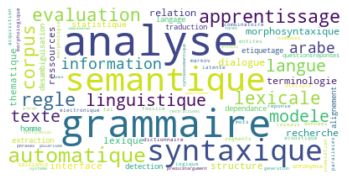

2006


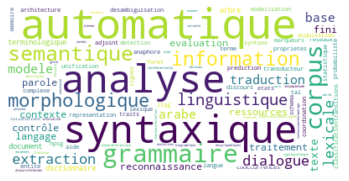

2007


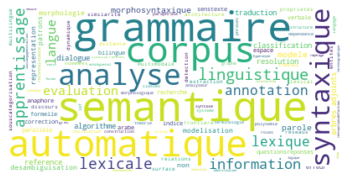

2008


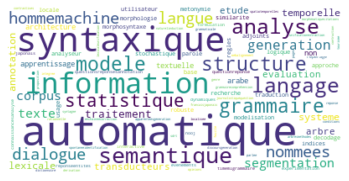

2009


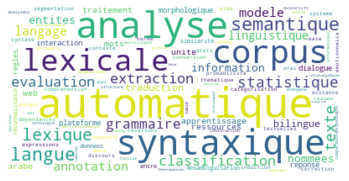

2010


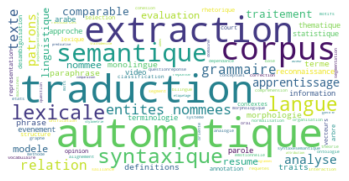

2011


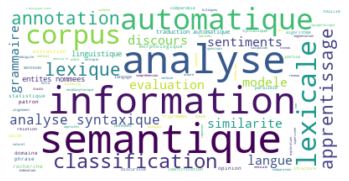

2012


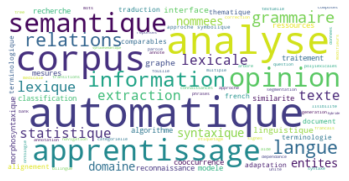

2013


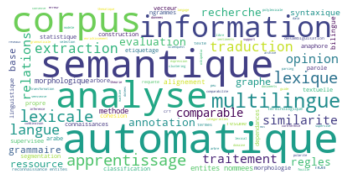

2014


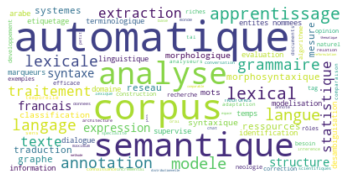

2015


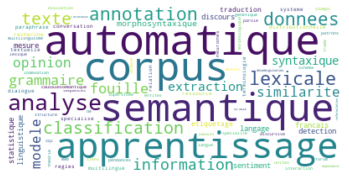

2016


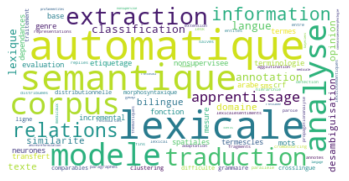

2017


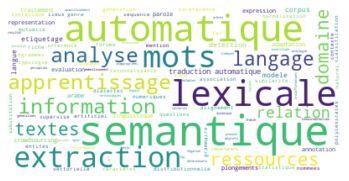

2018


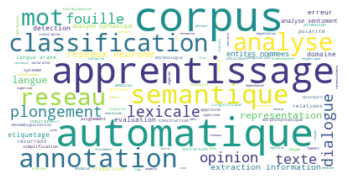

In [ ]:
# Nuage de mots : Keyword
dateMemory = df.iloc[0]["Date"]
corpus = ""

for index, row in df.iterrows():
    if row["Date"] == dateMemory:
        corpus = corpus + row["Keyword"]
    else:
        print(dateMemory)
        MakeWordCloud(corpus)
        dateMemory = row["Date"]
        corpus = row["Keyword"]

Diagramme en barre

In [ ]:
def ShowMostCommonWords(countData, countVectorizer):
    words = countVectorizer.get_feature_names()
    totalCounts = np.zeros(len(words))
    for data in countData:
        totalCounts += data.toarray()[0]
    
    countDictionary = (zip(words, totalCounts))
    countDictionary = sorted(countDictionary, key = lambda x : x[1], reverse = True)[0:10]
    words = [w[0] for w in countDictionary]
    counts = [w[1] for w in countDictionary]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize = (15, 15/1.6180))
    plt.subplot(title='Les 10 mots les plus récurrents')
    sb.set_context("notebook", font_scale = 1.25, rc = {"lines.linewidth": 1})
    sb.barplot(x_pos, counts, palette = 'pastel') # Couleur des barres
    plt.xticks(x_pos, words, rotation = 45) # Rotation de la légende
    plt.xlabel('Mots')
    plt.ylabel('Occurrence')
    plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


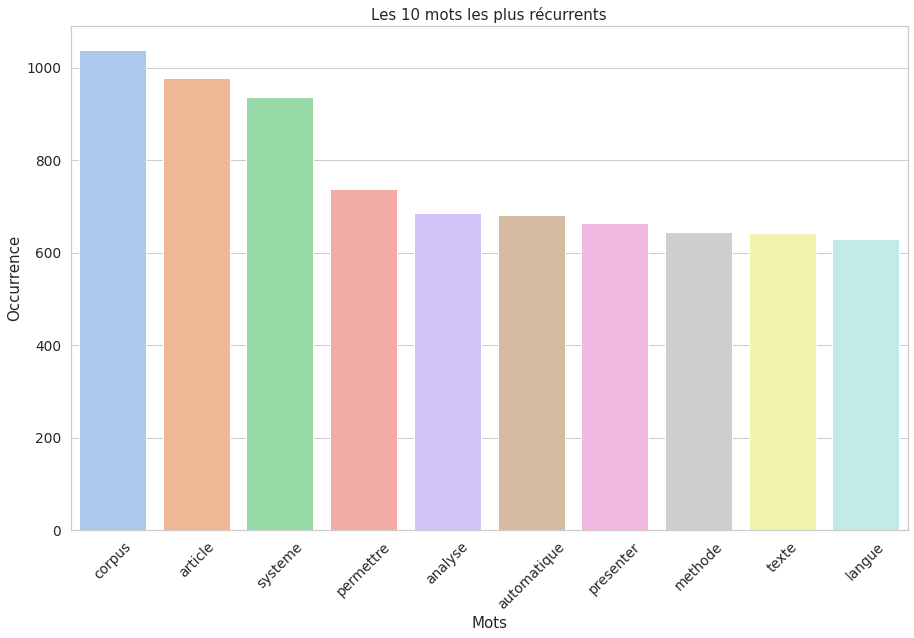

In [ ]:
sb.set_style('whitegrid')
stopWords = sw.words("french")

countVectorizer = CountVectorizer(stopWords)
countData = countVectorizer.fit_transform(df["Abstract"])
ShowMostCommonWords(countData, countVectorizer)

NUAGE DE MOTS ET DIAGRAMME EN BARRE AMELIORE

In [ ]:
# Pour obtenir les résultats présentés dans le rapport, nous avons réutilisé les lignes de codes précédentes.
# Premièrement, nous avons récrée le dataframe à partir du fichier d'origine.
# Ensuite, nous avons effectuer toutes les étapes de préprocessing SAUF la partie utilisant le lemmatizer.
# Enfin, nous utilisons le code suivant afin de supprimer tous les mots de 3 lettres ou moins dans le dataframe.

def GetRidOfThreeWords(df):
    columns = ["Title", "Abstract", "Corpus"]
    for column in columns:
        df[column] = df[column].str.replace(r'\b\w{1,3}\b', "")

GetRidOfThreeWords(df)

In [ ]:
def GetRifOfEtreAvoir(df):
    columns = ["Title", "Abstract", "Corpus"]
    for column in columns:
        df[column] = df[column].str.replace(r'etre', "")
        df[column] = df[column].str.replace(r'avoir', "")
    
GetRifOfEtreAvoir(df)

In [ ]:
df.head()

Title  ... Keyword
0  element conception systeme interpretation auto...  ...    none
1  informatisation dictionnaire explicatif etcomb...  ...    none
2  construction representation semantique graphe ...  ...    none
3                    systeme type lambdadrtascendant  ...    none
4    grammaire   comme grammair sens texteprecompile  ...    none

[5 rows x 5 columns]

LDA

In [ ]:
# Helper function
def FindTopics(model, countVectorizer, n_top_words):
    words = countVectorizer.get_feature_names()
    for index, topic in enumerate(model.components_):
        print("\nSujet #" + str(index+1) + ":")
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
lda = LDA(n_components=10, n_jobs=-1) # n_components représente le nombre de sujets que l'on veut
lda.fit(countData)

FindTopics(lda, countVectorizer, 3) # la valeur représente le nombre de mots que l'on veut pour définir un sujet


Sujet #1:
dialogue systeme proposer

Sujet #2:
systeme automatique analyse

Sujet #3:
article methode automatique

Sujet #4:
question reponse analyse

Sujet #5:
corpus article systeme

Sujet #6:
syntaxique article analyse

Sujet #7:
analyse syntaxique corpus

Sujet #8:
traduction systeme permettre

Sujet #9:
relation semantique texte

Sujet #10:
semantique permettre article


LDA - DEUXIEME APPROCHE

In [ ]:
def GetRidOfPunctuation(dfToken):
    columns = ["Title", "Abstract", "Corpus"]
    for column in columns:
        for index, row in dfToken.iterrows():
            dfToken[column] = dfToken.apply(lambda x: [i for i in x if i != '.'])
GetRidOfPunctuation(dfToken)

In [ ]:
import gensim
import gensim.corpora as corpora

allAbstract = []
for index, row in dfToken.iterrows():
    allAbstract.append(row["Abstract"])

id2word = corpora.Dictionary(allAbstract)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in allAbstract]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=5,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

print(lda_model.print_topics())

[(0, '0.111*"corpus" + 0.077*"base" + 0.060*"annotation" + 0.051*"donnee" + 0.048*"francais" + 0.021*"terme" + 0.020*"polylexfle" + 0.020*"lefle" + 0.018*"similarite" + 0.016*"alignement"'), (1, '0.100*"apprentissage" + 0.057*"vers" + 0.043*"contexte" + 0.028*"sens" + 0.016*"integration" + 0.015*"grammaire" + 0.014*"dependance" + 0.013*"alsacien" + 0.013*"caractere" + 0.012*"ameliorer"'), (2, '0.171*"automatique" + 0.048*"texte" + 0.040*"classification" + 0.040*"conversation" + 0.031*"systeme" + 0.028*"." + 0.019*"type" + 0.015*"acte" + 0.015*"tweet" + 0.013*"comprehension"'), (3, '0.088*"extraction" + 0.058*"lexical" + 0.031*"document" + 0.028*"desambiguisation" + 0.022*"information" + 0.022*"interaction" + 0.020*"simplification" + 0.016*"domaine" + 0.015*"manuscritancien" + 0.012*"reutilisation"'), (4, '0.099*"modele" + 0.058*"approche" + 0.045*"relation" + 0.027*"baser" + 0.025*"plongement" + 0.025*"distributionnel" + 0.023*"application" + 0.021*"recherche" + 0.019*"traitement" + 0.

LDA - AFFICHAGE

In [ ]:
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(dfToken)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in dfToken["Abstract"][0]]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, random_state=100, update_every=1, chunksize=10, passes=10, alpha='symmetric', iterations=100, per_word_topics=True)

pprint(lda_model.print_topics())

TypeError: ignored

In [ ]:
print(dfToken["Abstract"][0])

['considerer', 'travail', 'tache', 'traitement', 'automatique', 'viser', 'construire', 'partir', 'texte', 'issu', 'corpus', 'constat', 'accident', 'route', 'interpretation', 'compatible', 'dernier', 'proposer', 'illustration', 'sous', 'forme', 'sequence', 'image', 'fixe', '.', 'recherche', 'fruit', 'collaboration', 'entre', 'laboratoire', 'universitaire', 'entreprise', '.', 'prendre', 'appui', 'modele', 'grammaire', 'applicatif', 'cognitif', 'vise', 'particulier', 'expliquer', 'certain', 'niveau', 'cognitif', 'transfert', 'entre', 'representation', 'image', 'verbal', '.', 'revue', 'question', 'relatif', 'transcription', 'automatique', 'verbal', 'image', 'renvoyer', 'plus', 'particulierement', 'travail', '.', 'vandelois', 'groupe', 'langue', 'raisonnement', 'calcul', 'universite', 'paul', 'sabatier', 'ainsi', 'approche', 'proposer', 'systeme', 'sprint', '.', 'plus', 'proche', 'encore', 'preoccupation', '.', 'victorri', '.', 'enjalbert', 'posent', 'probleme', 'animation', 'visuel', 'issu

TSNE

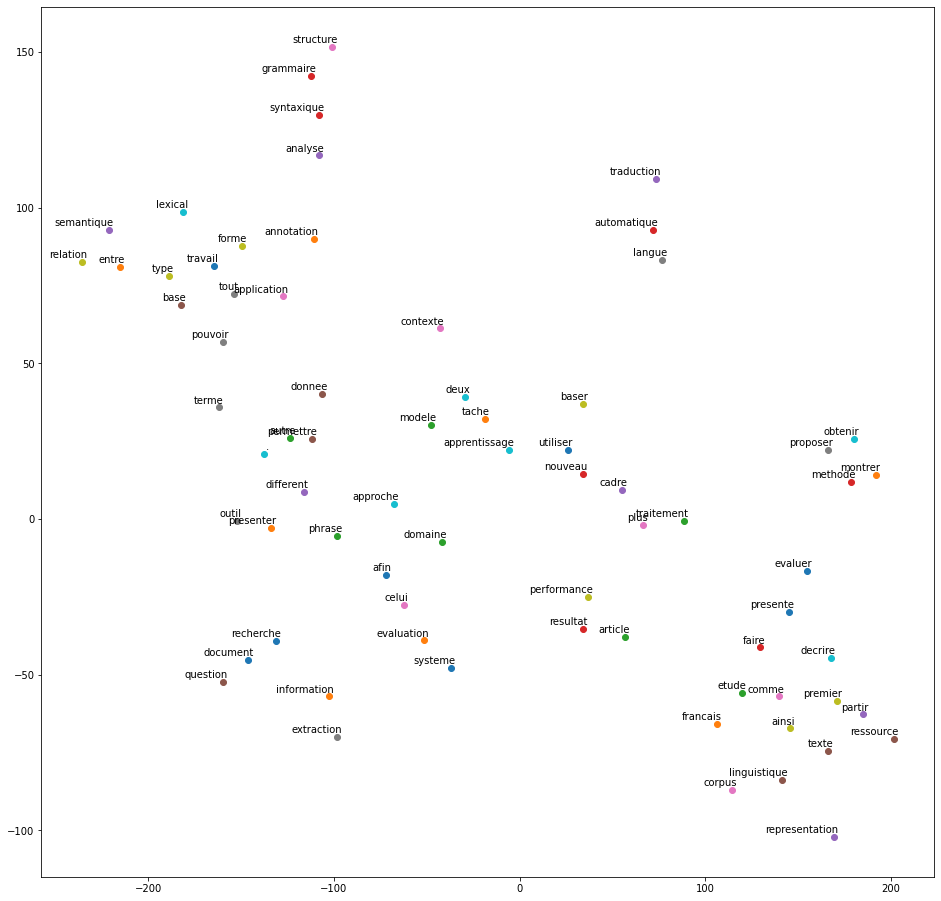

In [ ]:
from gensim.models import word2vec
from sklearn.manifold import TSNE

def CreateCorpus(dfToken):
    corpus = []

    for index, row in dfToken.iterrows():
        corpus.append(row["Abstract"])
    return corpus

def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=5000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

corpus = CreateCorpus(dfToken)
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)

tsne_plot(model)